In [131]:
# For Matrix Operations
import sklearn
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
import numpy as np
import pandas as pd

# For Plotting
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go
import mplcursors

# for Geospatial
import geopandas as gpd
from gerrychain import Graph
import networkx as nx

# For TDA
import gudhi
import gudhi.wasserstein
import gudhi.hera
import ot

# VERSIONS USED
# !pip install gerrychain==0.2.22
# !pip install shapely==2.0.2
# !pip install geopandas==0.12.2
#################

In [ ]:
gdf = gpd.read_file('TDA-Class-Notebook4/NC_VTD/NC_VTD.shp')

In [ ]:

gdf.plot(column=gdf.EL16G_PR_D/(gdf.EL16G_PR_R+gdf.EL16G_PR_D), cmap='RdBu')

In [ ]:
gdf_R_precincts = gdf[gdf.EL16G_PR_R > gdf.EL16G_PR_D]
gdf_R_precincts.plot(column=gdf_R_precincts.EL16G_PR_R/(gdf_R_precincts.EL16G_PR_R+gdf_R_precincts.EL16G_PR_D), cmap='Reds')


In [ ]:
gdf_R_precincts = gdf[gdf.EL16G_PR_R > gdf.EL16G_PR_D]
centroids = np.array([
    x.coords[0] for x in gdf_R_precincts.geometry.centroid
])


rips = gudhi.RipsComplex(max_edge_length = 100000, points = centroids)
#rips = gudhi.RipsComplex(max_edge_length=10, points=zip(X_Combined, Y_Combined))
simplex_tree = rips.create_simplex_tree(max_dimension = 2)
persistence = simplex_tree.persistence()

gudhi.plot_persistence_diagram(persistence)

In [ ]:
Elections = [
            # 2008 Gubernatorial election (democrat won)
            ('EL08G_GV_D', 'EL08G_GV_R'), 
            # 2008 Senate election (democrat won)
            ( 'EL08G_USS_', 'EL08G_US_1'),
            # 2010 Senate election (democrat won)
            ( 'EL10G_USS_', 'EL10G_US_1'),
            # 2012 Gubernatorial election (republican won) 
            ( 'EL12G_GV_D', 'EL12G_GV_R'),
            # 2014 Senate election (republican won)
            ( 'EL14G_US_1', 'EL14G_USS_'),
            # 2012 Presidential election
            ( 'EL12G_PR_D', 'EL12G_PR_R'),
            # 2016 Presidential election
            ( 'EL16G_PR_D', 'EL16G_PR_R'),
            # 2016 Senate election (republican won)
            ( 'EL16G_US_1', 'EL16G_USS_'),
            # 2016 Gubernatorial election (democrat won)
            ('EL16G_GV_D', 'EL16G_GV_R')]

Election_Names = ['2008 Gubernatorial election', '2008 Senate election', '2010 Senate election', '2012 Gubernatorial election', '2014 Senate election', 
                  '2012 Presidential election', '2016 Presidential election', '2016 Senate election', '2016 Gubernatorial election']

Winners = ['blue'] * 3 + ['red'] * 5 + ['blue']

In [ ]:
for Election in Elections:
    print(Election)
    gdf.plot(column=gdf[Election[0]]/(gdf[Election[0]]+gdf[Election[1]]), cmap='RdBu', legend = True)
    plt.show()

In [ ]:
for i, Election in enumerate(Elections):
    R_Precincts = gdf[gdf[Election[0]] < gdf[Election[1]]]
    centroids = np.array([
        x.coords[0] for x in R_Precincts.geometry.centroid
    ])

    rips = gudhi.RipsComplex(max_edge_length = 100000, points = centroids)

    print("Simplex Tree for {}".format(Election_Names[i]))
    simplex_tree = rips.create_simplex_tree(max_dimension = 2)
    persistence = simplex_tree.persistence()

    gudhi.plot_persistence_diagram(persistence)
    plt.show()


### Distance Matrices

#### L2 Distance

In [128]:
Democrat_Vectors = np.array([gdf[Election[0]]/ (gdf[Election[0]]+gdf[Election[1]]) for Election in Elections])

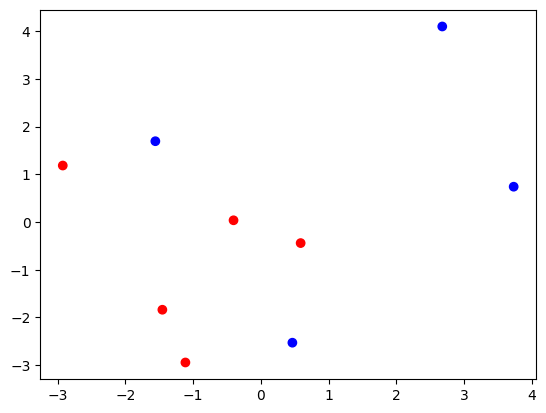

In [129]:
L2_Distances = np.zeros( (Democrat_Vectors.shape[0], Democrat_Vectors.shape[0]) )
for i in range(L2_Distances.shape[0]):
    for j in range(i, L2_Distances.shape[1]):
        L2_Distances[i][j] = np.linalg.norm( Democrat_Vectors[i] - Democrat_Vectors[j])
L2_Distances += L2_Distances.transpose()

Embedding = MDS(n_components = 2, metric = True, random_state = 32, dissimilarity = 'precomputed').fit_transform(L2_Distances)


# Plotting
fig, ax = plt.subplots()

scatter = ax.scatter(Embedding[:,0], Embedding[:,1], c = Winners)

# Getting Name on Hover
def on_plot_hover(event):

    ind = event.ind

    mplcursors.cursor(scatter).annotations.remove()

    for i in ind:
        mplcursors.cursor(scatter).add_annotations(Election_Names[i])
        
mplcursors.cursor(scatter, hover=True).connect("add", on_plot_hover)
plt.show()


### Wasserstein Distance

#### Adjacency Method

In [179]:
def Adjacency_Persistence(gdf, Election, dimension = None):
  # Input: Election and corresponding simplicial complex
  # First index should always be democrat vote share
  # Second index should always be republican vote share

  # Output
  # Persistence diagram in requested dimension corresponding to adjacency filtration on graph

  ############################################################################################################################################
  # Making Graph #
  ############################################################################################################################################
  graph = Graph.from_geodataframe(gdf, adjacency='queen', ignore_errors = True)
  scomplex = gudhi.SimplexTree()
  for i in graph.nodes:
      scomplex.insert([i]) #add a 0-simplex, given as a list with just one vertex

  for e in graph.edges:
      scomplex.insert([e[0], e[1]]) #add a 1-simplex

  all_cliques = nx.enumerate_all_cliques(graph)

  all_triangles = [x for x in all_cliques if len(x) == 3]

  for t in all_triangles:
      scomplex.insert([t[0], t[1], t[2]]) #add a 2-simplex
  ############################################################################################################################################
  # Filtration Step #
  ############################################################################################################################################
  for v in graph.nodes:
      scomplex.assign_filtration(
        [v], #we have to put [] here because a 0-simplex is technically a list with one element
        filtration=graph.nodes[v][Election[0]]/(graph.nodes[v][Election[0]]+graph.nodes[v][Election[1]])
      )

  scomplex.make_filtration_non_decreasing()
  
  if dimension == None:  
    persistence = scomplex.persistence()

  else:
    scomplex.compute_persistence()
    persistence = scomplex.persistence_intervals_in_dimension(dimension)

  return persistence 

In [183]:
# Calculating Dimension zero persistence diagrams
PDDS_0 = [Adjacency_Persistence(gdf, Election, 0) for Election in Elections]

# Wasserstein Distances
Adj_Distances = np.zeros( (len(PDDS_0), len(PDDS_0)) )
for i in range(Adj_Distances.shape[0]):
    for j in range(i, Adj_Distances.shape[1]):
        Adj_Distances[i][j] = gudhi.hera.wasserstein_distance(PDDS_0[i], PDDS_0[j])
Adj_Distances += Adj_Distances.transpose()



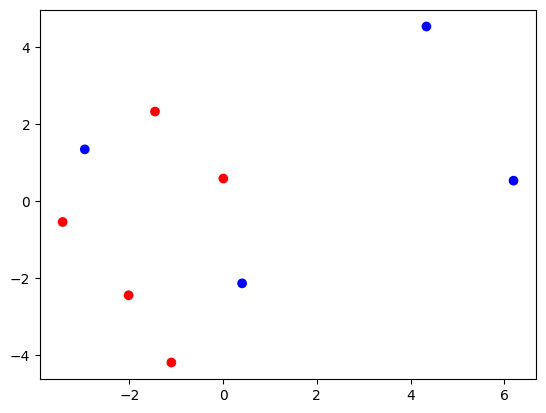

In [184]:
# Doing MDS and PLotting
Embedding = MDS(n_components = 2, metric = True, random_state = 32, dissimilarity = 'precomputed').fit_transform(Adj_Distances)

# Plotting
fig, ax = plt.subplots()

scatter = ax.scatter(Embedding[:,0], Embedding[:,1], c = Winners)

# Getting Name on Hover
def on_plot_hover(event):

    ind = event.ind

    mplcursors.cursor(scatter).annotations.remove()

    for i in ind:
        mplcursors.cursor(scatter).add_annotations(Election_Names[i])
        
mplcursors.cursor(scatter, hover=True).connect("add", on_plot_hover)
plt.show()

#### Centroid Method

In [ ]:
def Get_Persistence(Election, dimension = None):
    # takes the election tuples as an input (any two columns of a dataframe will work
    # Democrat must be in index 0 and republican in index 1

    R_Precincts = gdf[gdf[Election[0]] < gdf[Election[1]]]
    centroids = np.array([
    x.coords[0] for x in R_Precincts.geometry.centroid
])
    
    rips = gudhi.RipsComplex(max_edge_length = 100000, points = centroids)
    #rips = gudhi.RipsComplex(max_edge_length=10, points=zip(X_Combined, Y_Combined))
    simplex_tree = rips.create_simplex_tree(max_dimension = 2)
    if dimension == None:
        persistence = simplex_tree.persistence()
    else:
        simplex_tree.compute_persistence()
        persistence = simplex_tree.persistence_intervals_in_dimension(dimension)

    return persistence

In [127]:
# Dimension zero persistence diagrams
PDDS_0 = [Get_Persistence(Election, 0) for Election in Elections]

# Wasserstein Distances
Cent_Distances = np.zeros( (len(PDDS_0), len(PDDS_0)) )
for i in range(Cent_Distances.shape[0]):
    for j in range(i, Cent_Distances.shape[1]):
        W_Distances[i][j] = gudhi.hera.wasserstein_distance(PDDS_0[i], PDDS_0[j])
Cent_Distances += Cent_Distances.transpose()


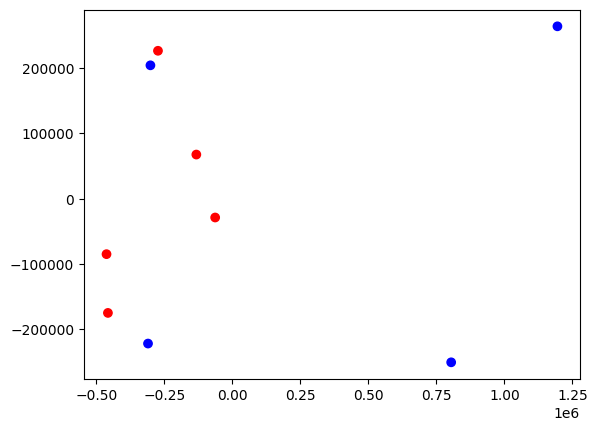

In [126]:
Embedding = MDS(n_components = 2, metric = True, random_state = 32, dissimilarity = 'precomputed').fit_transform(Cent_Distances)

# Plotting
fig, ax = plt.subplots()

scatter = ax.scatter(Embedding[:,0], Embedding[:,1], c = Winners)

# Getting Name on Hover
def on_plot_hover(event):

    ind = event.ind

    mplcursors.cursor(scatter).annotations.remove()

    for i in ind:
        mplcursors.cursor(scatter).add_annotations(Election_Names[i])
        
mplcursors.cursor(scatter, hover=True).connect("add", on_plot_hover)
plt.show()

#### Vinyard Distance

In [153]:
t = 11
ts = np.linspace(0,1,t)
Delta = (Democrat_Vectors[0] - Democrat_Vectors[1])

hs = np.array([Democrat_Vectors[0] + (Democrat_Vectors[0] - Democrat_Vectors[1]) * t for t in ts])
hs.shape

(11, 2692)

In [ ]:
def Adjacency_Persistence_Vinyard(gdf, Election, dimension = None):
  # Input: Election and corresponding simplicial complex
  # First index should always be democrat vote share
  # Second index should always be republican vote share

  # Output
  # Persistence diagram in requested dimension corresponding to adjacency filtration on graph

  ############################################################################################################################################
  # Making Graph #
  ############################################################################################################################################
  graph = Graph.from_geodataframe(gdf, adjacency='queen', ignore_errors = True)
  scomplex = gudhi.SimplexTree()
  for i in graph.nodes:
      scomplex.insert([i]) #add a 0-simplex, given as a list with just one vertex

  for e in graph.edges:
      scomplex.insert([e[0], e[1]]) #add a 1-simplex

  all_cliques = nx.enumerate_all_cliques(graph)

  all_triangles = [x for x in all_cliques if len(x) == 3]

  for t in all_triangles:
      scomplex.insert([t[0], t[1], t[2]]) #add a 2-simplex
  ############################################################################################################################################
  # Filtration Step #
  ############################################################################################################################################
  for v in graph.nodes:
      scomplex.assign_filtration(
        [v], #we have to put [] here because a 0-simplex is technically a list with one element
        filtration=graph.nodes[v][Election[0]]/(graph.nodes[v][Election[0]]+graph.nodes[v][Election[1]])
      )

  scomplex.make_filtration_non_decreasing()
  
  if dimension == None:  
    persistence = scomplex.persistence()

  else:
    scomplex.compute_persistence()
    persistence = scomplex.persistence_intervals_in_dimension(dimension)

  return persistence 

In [188]:
PDDS_0 = [Adjacency_Persistence(gdf,Election, 0) for Election in hs]

PDDS_0 = []
for Election in Elections:
    

def Get_Vinyard(PDD, t = 11):
##########
    # input:
        # a series of persistence diagrams that come from a straight line homotopy
        # the dimension of persistence you want
    # output:
        # series of persistence diagrams: hs
        # persistence vinyard polotted in 3d space: res
        # death value of largest persistence: mx

##########


    # creates equal intervals from 0 to 100
    ts = np.linspace(0,1,t)

# tracking each vine. the third entry tracks what vine is matche dup to what wasserstein point
    # vines[0] is birth frame
    # vines[1] is death frame
    # vines[2] keeps track of what point the vine is in the corresponding persistence diagram
    vines = [[0, None, [x,]] for x in range(len(PDD[0]))]
    # each vine is matched to itself in the ends matrix
    ends = {x:x for x in range(len(PDD[0]))}

    for i in range(1, len(ts)):
        dist, match = gudhi.hera.wasserstein_distance(PDD[i-1], PDD[i], matching = True)

        baby = [] 

        new_ends = {k:ends[k] for k in ends}
        for j, (x,y) in enumerate(match):
            if x == -1:
                baby.append(j)
            elif y == -1:
                # ends the vine
                
                # we record death frame
                vines[ends[x]][1] = i
                # -1 tells us the vine is dead in our PD
                vines[ends[x]][2].append(-1)
            else:
                # updating vines. Adding the match to our vines matrix
                vines[ends[x]][2].append(y)
                # setting ends to new_ends for the next iteration
                new_ends[y] = ends[x] 

        for j in baby:
            x, y = match[j]
            new_ends[y] = len(vines)
            vines.append([i, None, [y,]])
            # print(f"new {y} -> *")

        for k in [l for l in ends]: 
            if k >= len(PDD[i]):
                del new_ends[k]

        ends = new_ends


    # this block takes the tracking in vines[i][2] and replaces it with the numpy array of the vines birth and death times.
    # these times are taken at each time step of our vinyard
    # for example: poss[1][2][3] is the birth/death times of vine number 2 at time step 4. Note that indices are 1 less than their frame #
    poss = vines
    for i,_ in enumerate(vines):
        repl = []
        for j,x in enumerate(vines[i][2]):
            # if vine is dead at that frame
            if x == -1:
                repl.append(np.mean(PDD[vines[i][0]+j-1][vines[i][2][j-1]])*np.ones((2,))) # proj prev
            else:
                repl.append(PDD[vines[i][0]+j][x])
        poss[i][2] = np.array(repl)




    # these are the vine values in 3d space

    # we iterate through each vine, to create a res entry (res[0] corresponds to vine zero)
    # res[0][b(t) -> d(t)] is a triple list consisting of:
        # [time value, birth time, death time]

    res = [[[ts[p[0]+np.arange(len(p[2]))][i], *x] for i,x in enumerate(p[2])] for p in poss]


    mx = np.max([np.max(p[2]) for p in poss if np.inf not in p[2]])
    # getting the max death time of all the vines

    return res, mx, hs

Test_Vinyard = Get_Vinyard(PDDS_0, 11)

IndentationError: expected an indented block after 'for' statement on line 4 (3428177339.py, line 6)